In [1]:
from DistantSpeech.beamformer.utils import load_audio
from scipy.signal import convolve as conv
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from DistantSpeech.adaptivefilter.BaseFilter import BaseFilter, awgn
from DistantSpeech.adaptivefilter import FastFreqLms, SubbandLMS
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.transform.transform import Transform
from DistantSpeech.transform.subband import Subband
from DistantSpeech.beamformer.utils import pt
from DistantSpeech.adaptivefilter import BaseFilter, awgn, FastFreqLms, Mdf
from DistantSpeech.adaptivefilter.aec import Aec
from DistantSpeech.beamformer.utils import pmesh

(180000,)


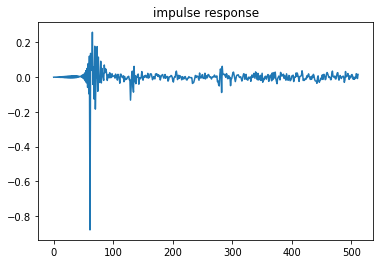

In [2]:
sim = 1

src = audioread('/home/wangwei/work/lanxun/pcm/dac_data16000.wav')
data = audioread('/home/wangwei/work/lanxun/pcm/mic_data_ali.wav')
data = data[:360000]
src = src[:len(data)]

if sim:

    # load source single and rir
    src = load_audio('/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav')
    src = src[:180000]
    # src = np.random.rand(len(src))-0.5# * np.sqrt(npower)
    interf = load_audio('/home/wangwei/work/DistantSpeech/samples/audio_samples/interf.wav')
    print(src.shape)
    rir = load_audio('/home/wangwei/work/DistantSpeech/DistantSpeech/adaptivefilter/rir.wav')
    rir = rir[200:]

    filter_len = 512

    rir = rir[:filter_len, np.newaxis]*4
    plt.figure()
    plt.plot(rir)
    plt.title('impulse response')
    plt.show()

    # src = awgn(src, 30)

    SNR = 30
    data_clean = conv(src, rir[:, 0])
    data = data_clean[:len(src)]

    # data[100000:180000] = data[100000:180000] + speech[100000:180000] * 2
    data[:len(interf)] = data[:len(interf)] + interf

    data = awgn(data, SNR)

In [3]:
# pt(speech[100000:140000])

In [4]:
filter_len = 512
mdf = Aec(filter_len=filter_len, mu=1.e-1, num_block=4, alpha=0.9, prop=False)
valid_len = len(src)-mdf.filter_len  # discard last frame
output_mdf = np.zeros(data.shape)
n_frames = int(output_mdf.shape[0]/mdf.block_len)
mu_opt = np.zeros((mdf.half_bin, n_frames))

leak_estimate = np.zeros(data.shape)

est_err = np.zeros(valid_len)

t = 0
for n in tqdm(range((valid_len))):
    if np.mod(n, mdf.block_len) == 0:
        input_vector = src[n: n +  mdf.block_len]
        d_vector = data[n : n + mdf.block_len]
        err, w_mdf = mdf.update(input_vector, d_vector)
        output_mdf[n : n + mdf.block_len] = err[:, 0]
        leak_estimate[n : n + mdf.block_len] = mdf.leak_estimate
        mu_opt[:, t] = mdf.mu_opt[:, 0]
        t = t + 1

        if n< 25000:
            w_est = mdf.w

        est_err[n : n + mdf.block_len] = np.sum(np.abs(rir - mdf.w[:len(rir)])**2)

        # eta[n : n + mdf.block_len] = mdf.beta[16, 0]
        # eta[n : n + mdf.block_len] = mdf.eta

 19%|█▉        | 34433/179488 [00:00<00:00, 172559.40it/s]

...transfer...

...transfer...

...transfer...

...transfer...

...transfer...

...transfer...



100%|██████████| 179488/179488 [00:01<00:00, 175708.20it/s]


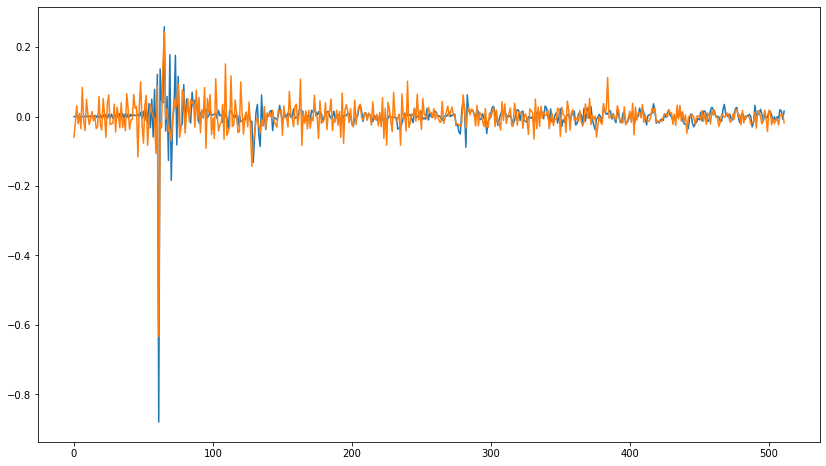

In [5]:
plt.figure(figsize=(14,8))
plt.plot(rir)
plt.plot(mdf.w)
plt.show()

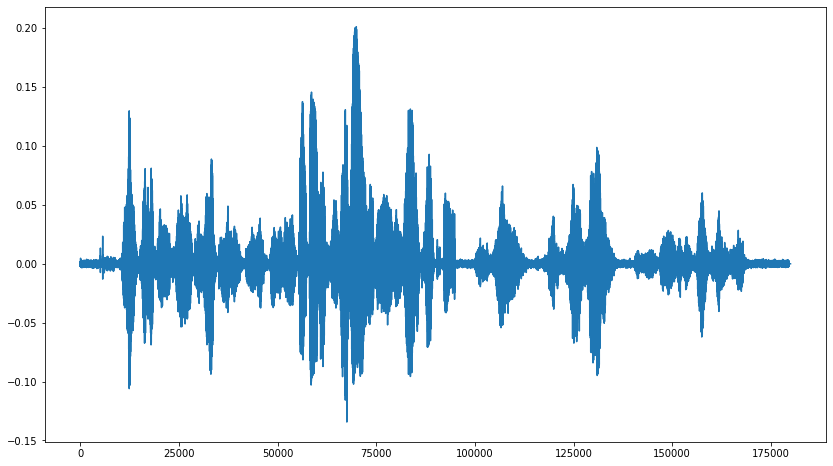

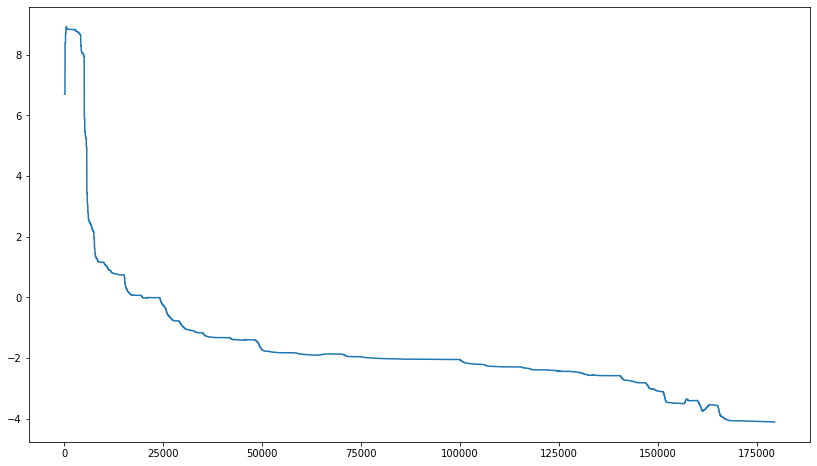

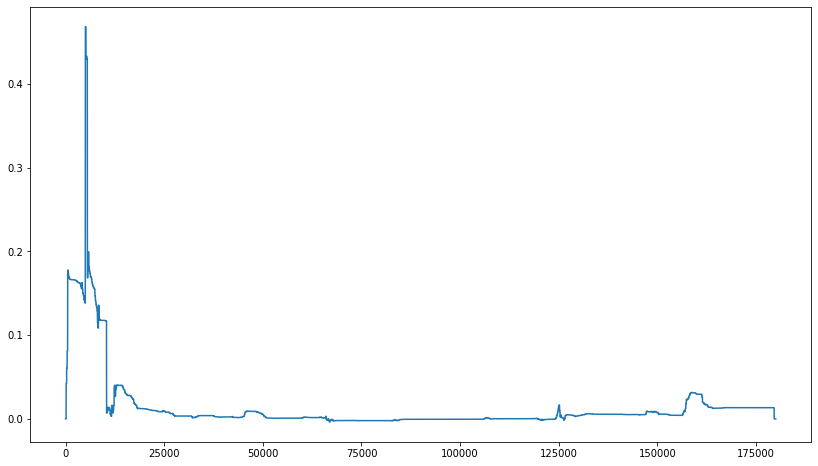

-0.0037803939144986165


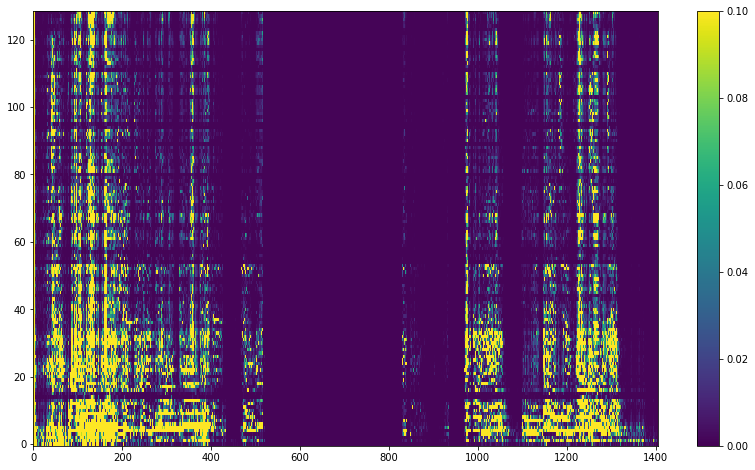

In [6]:
pt(output_mdf)
plt.figure(figsize=(14,8))
plt.plot(10 * np.log(est_err / np.sum(np.abs(rir[:, 0])**2) + 1e-6))
plt.show()
pt(leak_estimate)
print(min(leak_estimate))
pmesh(mu_opt)
# audiowrite('aec/ref2.wav', src)
# audiowrite('aec/mic2.wav', data)
audiowrite('aec/out.wav', output_mdf)